In [18]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from pearls.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_features = 1 # dimensionality
n_index_points = 256 # nbr of index points
n_samples = 5 # nbr of GP prior samples
jitter = 1e-6
kernel_cls = kernels.ExponentiatedQuadratic

seed = 42 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

# index points
X_q = np.linspace(-1.0, 1.0, n_index_points).reshape(-1, n_features)

# kernel specification
observation_noise_variance, length_scale = np.ogrid[1e-5:0.5:100j, 1e-5:5e-1:100j]
kernel = kernel_cls(length_scale=length_scale)

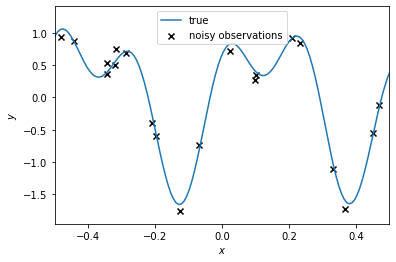

In [13]:
n_train = 20 # nbr training points in synthetic dataset
true_observation_noise_variance = 1e-1

f = lambda x: np.sin(12.0*x) + 0.66*np.cos(25.0*x)

X = random_state.rand(n_train, n_features) - 0.5
eps = true_observation_noise_variance * random_state.randn(n_train, n_features)
Y = np.squeeze(f(X) + eps)

fig, ax = plt.subplots()

ax.plot(X_q, f(X_q), label="true")
ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.legend()

ax.set_xlim(-0.5, 0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

In [14]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=X,
    observation_noise_variance=observation_noise_variance
)

In [15]:
nll = - gp.log_prob(Y)
nll

<tf.Tensor 'Neg_2:0' shape=(100, 100) dtype=float64>

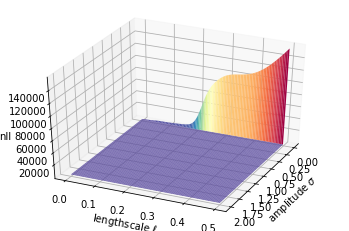

In [16]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d", azim=25, elev=35))

with tf.Session() as sess:

    ax.plot_surface(observation_noise_variance, length_scale, sess.run(nll),
                    rstride=1, cstride=1, edgecolor='none', cmap="Spectral_r")

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")
ax.set_zlabel("nll")

plt.show()

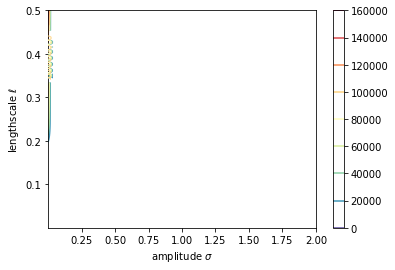

In [17]:
_observation_noise_variance, _length_scale = np.broadcast_arrays(observation_noise_variance, length_scale)

fig, ax = plt.subplots()

with tf.Session() as sess:

    contours = ax.contour(_observation_noise_variance, _length_scale, sess.run(nll), cmap="Spectral_r")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.1f')

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")

plt.show()

In [7]:
_amplitude, _length_scale = np.broadcast_arrays(amplitude, length_scale)

In [8]:
amplitude, length_scale = amplitude[10:50:10], length_scale[...,5:45:10]
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)

In [9]:
Z = np.dstack(np.broadcast_arrays(amplitude, length_scale)).reshape(-1, 2)
Z.shape

(16, 2)

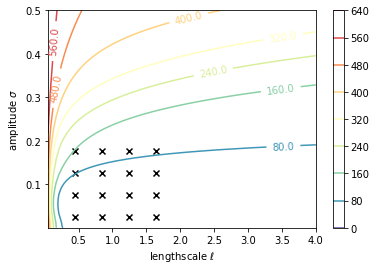

In [10]:
fig, ax = plt.subplots()

ax.scatter(*Z.T, color='k', marker='x')

with tf.Session() as sess:

#     ax.plot_surface(amplitude, length_scale, sess.run(neg_log_likelihood), cmap="coolwarm")
    contours = ax.contour(_amplitude, _length_scale, sess.run(nll), cmap="Spectral_r")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.1f')

ax.set_xlabel(r"lengthscale $\ell$")
ax.set_ylabel(r"amplitude $\sigma$")

plt.show()

In [14]:
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel, index_points=X_q, observation_index_points=X, observations=Y,
    observation_noise_variance=observation_noise_variance, jitter=jitter
)

gp_samples = gp_sample_custom(gprm, n_samples, seed=seed)

with tf.Session() as sess:
    gp_samples_arr = sess.run(gp_samples)

data = dataframe_from_gp_samples(gp_samples_arr, X_q, 
                                 amplitude, length_scale,
                                 n_samples)

In [15]:
def dateplot(X, Y, ax=None, *args, **kwargs):

    if ax is None:
        ax = plt.gca()

    ax.scatter(X, Y, s=8.0**2, marker='x', color='k')

In [16]:
data = dataframe_from_gp_samples(gp_samples_arr, X_q,
                                 amplitude, length_scale, n_samples)

In [17]:
golden_ratio = 0.5 * (1 + np.sqrt(5))

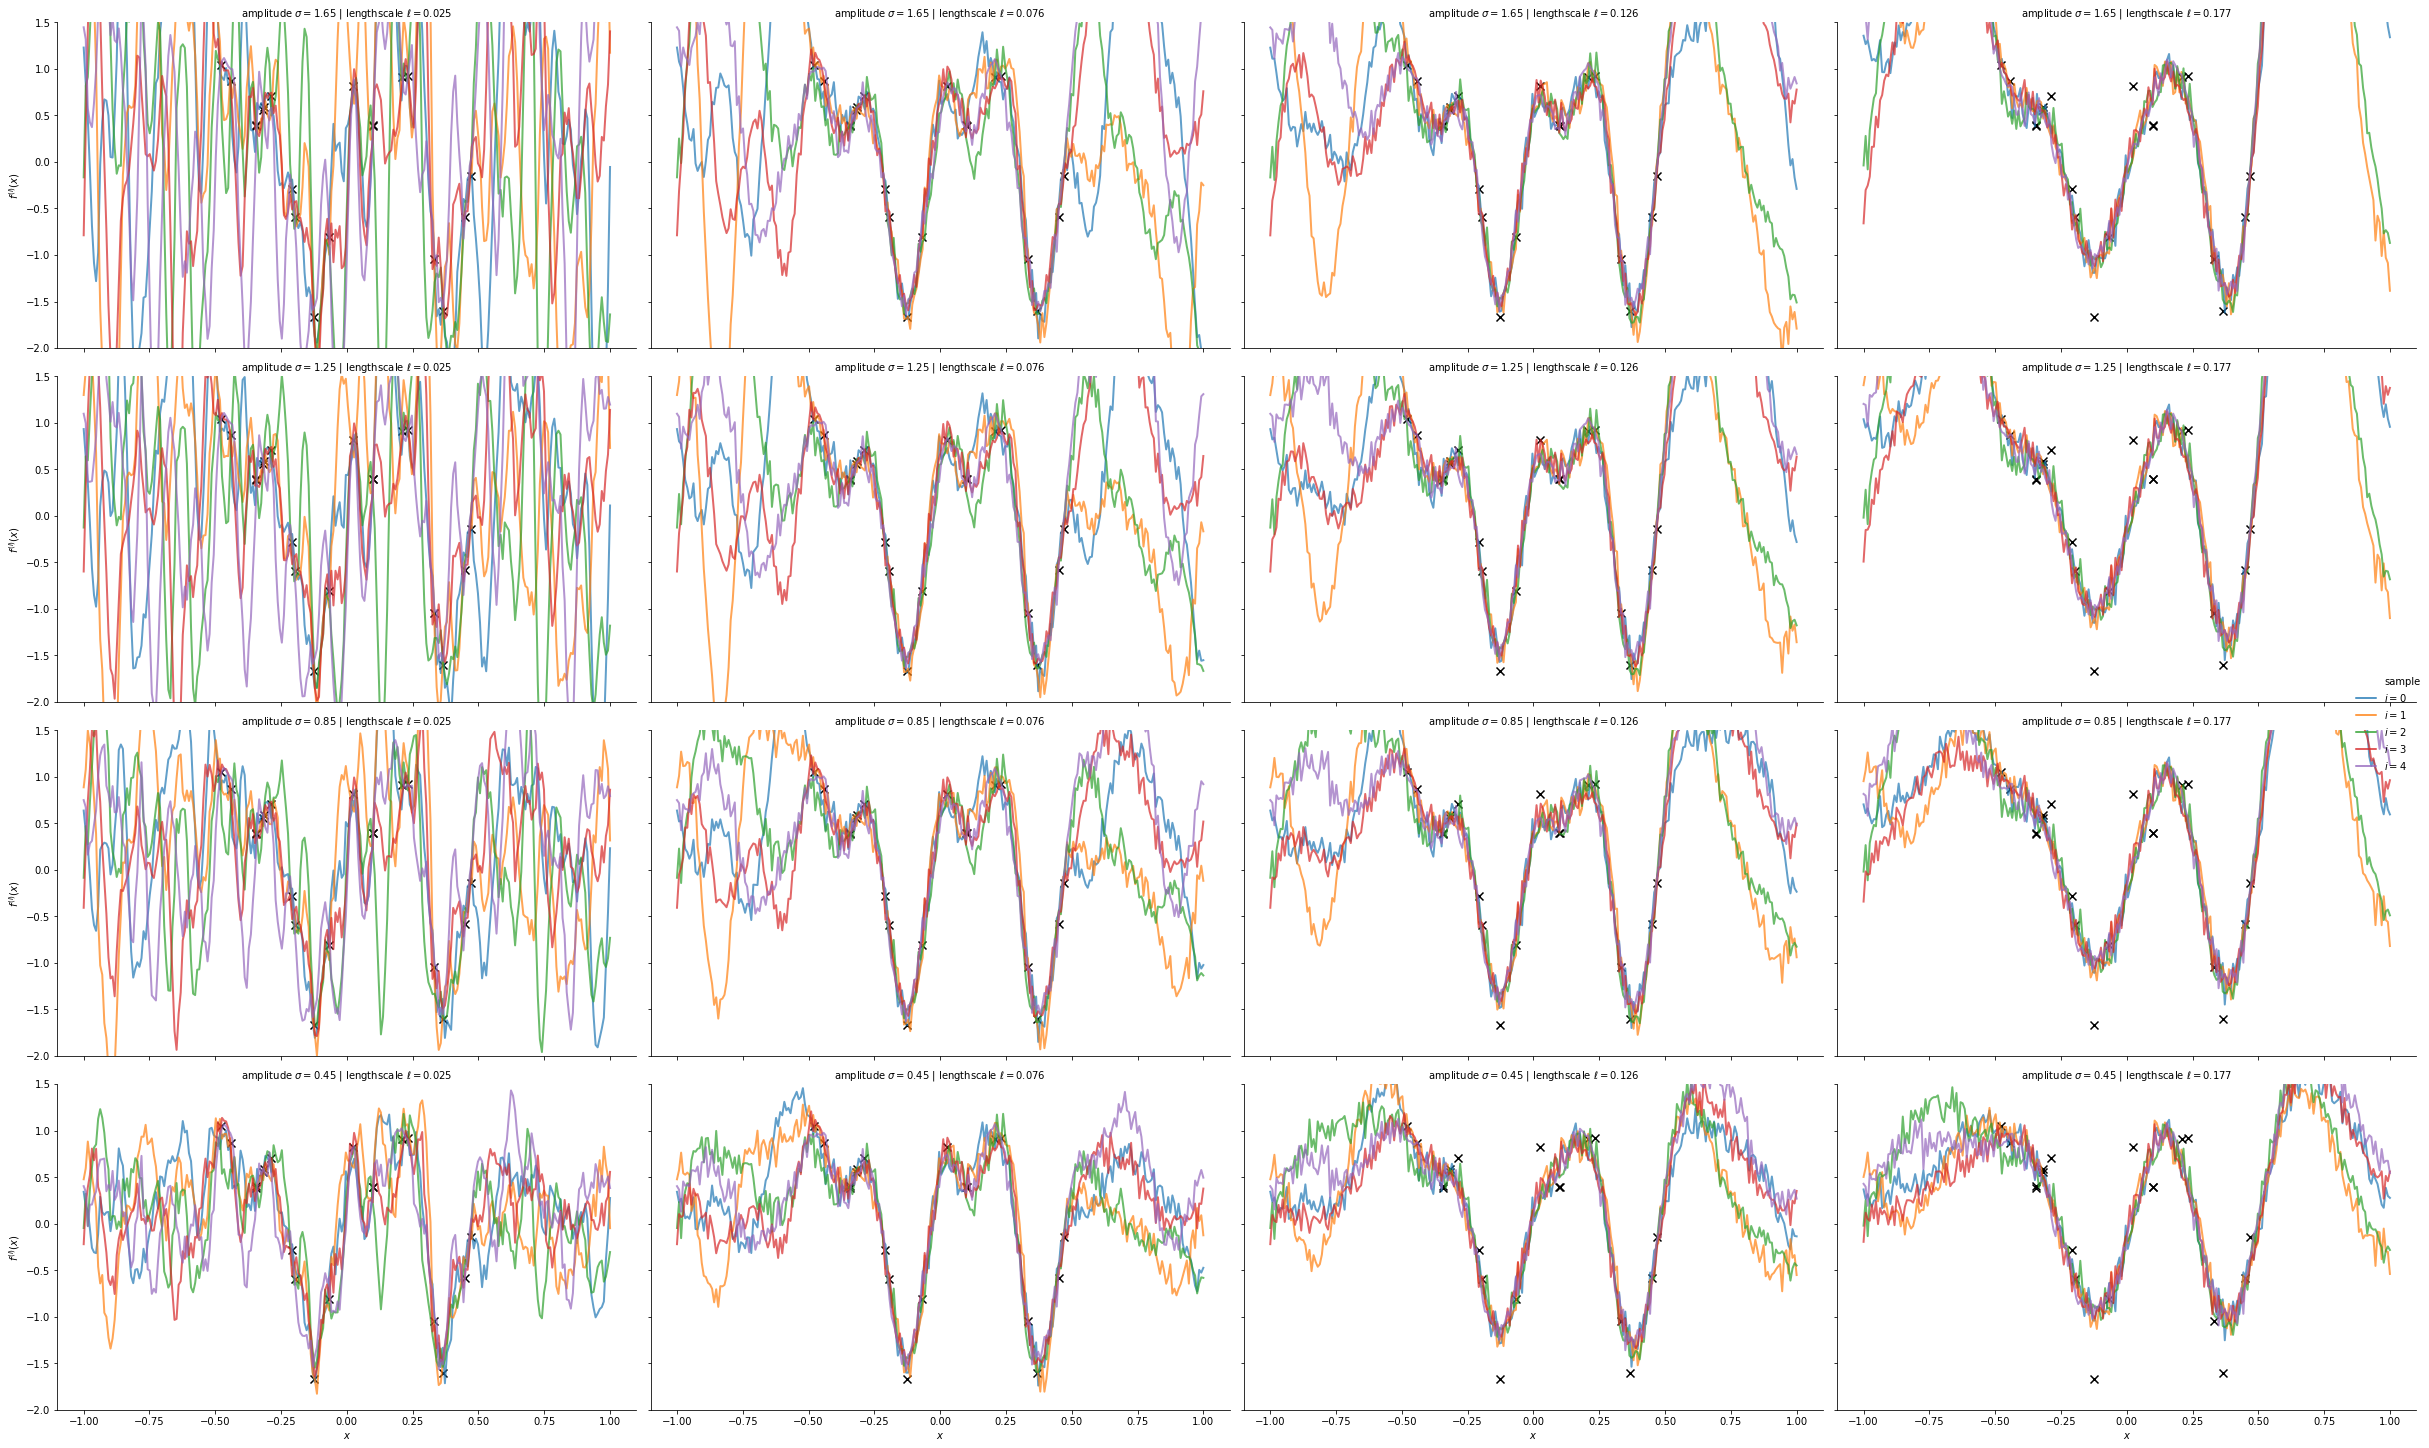

In [18]:
g = sns.relplot(x="index_point", y="function_value", hue="sample",
                row="amplitude", row_order=amplitude[::-1].squeeze(), col="length_scale", 
                height=5.0, aspect=golden_ratio, kind="line", data=data, alpha=0.7, linewidth=2.0)
g.map(dateplot, X=X, Y=Y)
g.set_titles(row_template=r"amplitude $\sigma={{{row_name:.2f}}}$",
             col_template=r"lengthscale $\ell={{{col_name:.3f}}}$")
g.set_axis_labels(r"$x$", r"$f^{(i)}(x)$")
g.set(ylim=(-2.0, 1.5))